In [1]:
import os
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, Resize, Lambda, Normalize
from torch.utils.data import DataLoader
from skimage.measure import compare_ssim, compare_mse
from sklearn.preprocessing import RobustScaler
from monai.networks.nets import UNet

%autoreload 2
from networks import *
from utils import set_device, set_seed
from losses import PixelAWLoss
from datasets import UndersampledUltrasoundDataset3D


import matplotlib.pyplot as plt
import progressbar
import plotly.express as px
import plotly.graph_objects as go

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=300
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)


# Losses
l2loss     = nn.MSELoss(reduction="sum")
awloss     = PixelAWLoss(reduction="sum", epsilon=3e-5)


Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


# MRI Dataset 

In [3]:
def scale2range(x, range=[-1, 1]):
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

def resize(x, nc, h, w):
    return torch.nn.functional.interpolate(x.unsqueeze(0).unsqueeze(0), size=(nc, h, w)).squeeze(0).squeeze(0)

def robust_scalar(x):
    shape = x.shape
    rs = RobustScaler()
    x = rs.fit_transform(x.flatten(start_dim=1))
    return torch.tensor(x.reshape(shape), dtype=torch.float32)

def clip_outliers(x, fence="outer"):
    f = 1.5 if fence=="inner" else 3.0
    q1 = torch.quantile(x, q=0.25)
    q3 = torch.quantile(x, q=0.75)
    iqr = q3 - q1
    lower = q1 - f*iqr
    upper = q3 + f*iqr
    x[torch.where(x < lower)] = lower
    x[torch.where(x > upper)] = upper
    return x



{'name': 'UndersampledUltrasoundDataset3D', 'path': '/media/dekape/HDD/Ultrasound-MRI_volumes/173940', 'maxsamples': None, 'transform': Compose(
    Lambda()
    Lambda()
    Lambda()
    Normalize(mean=0.0, std=1.0)
), 'undersample_width': (1, 1, 2), 'mode': 'mri', 'fill': 0.0, 'len': 1} 

torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


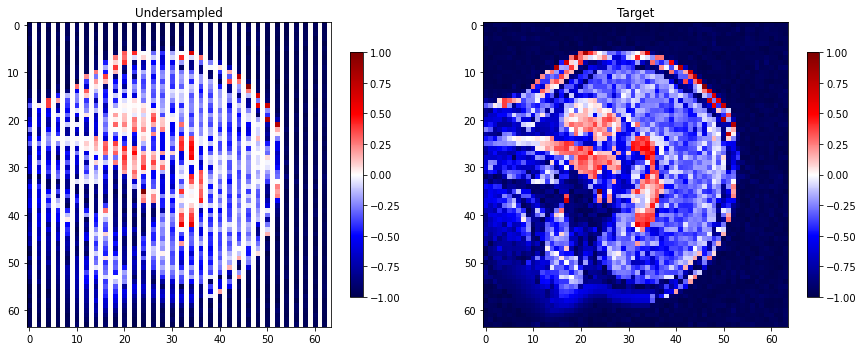

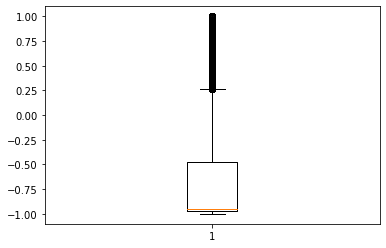

{'max': tensor(1.),
 'min': tensor(-1.),
 'mean': tensor(-0.3474),
 'std': tensor(0.4593),
 'shape': torch.Size([64, 64, 64])}

In [4]:
# Dataset
path = os.path.abspath("/media/dekape/HDD/Ultrasound-MRI_volumes/173940")
train_transform = Compose([
                    Lambda(lambda x: resize(x, 64, 64, 64)),
                    # Lambda(lambda x: x / x.abs().max()),
                    Lambda(lambda x: clip_outliers(x)),
                    # Lambda(lambda x: robust_scalar(x)),
                    Lambda(lambda x: scale2range(x, [-1, 1])),
                    Normalize(0., 1.),
                    ])
trainds = UndersampledUltrasoundDataset3D(path, 
                                        mode="mri",
                                        transform=train_transform,
                                        undersample_width=(1,1,2))
print(trainds, "\n")

# Dataloader
train_loader = DataLoader(trainds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

# Sample for visualisation
x_sample, y_sample = trainds[0]
print(x_sample.shape, y_sample.shape)

idx = int(x_sample.shape[0]/2)
vmin, vmax, cmap =  None, None, "seismic"
fig, axs = plt.subplots(1,2, figsize=(15,15))

im = axs[0].imshow(x_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[0], shrink=0.3)
axs[0].set_title("Undersampled")

im = axs[1].imshow(y_sample[idx], cmap=cmap, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs[1], shrink=0.3)
axs[1].set_title("Target")
plt.show()

plt.boxplot(y_sample.flatten().numpy())
plt.show()

trainds.info(nsamples=1)

## Model 

In [5]:
def make_model(channels=64):
    return UNet(
    spatial_dims=2,
    in_channels=channels,
    out_channels=channels,
    channels=(16, 32, 64, 128, 256),
    strides=tuple([2 for i in range(channels)]), 
    num_res_units=2,
    act="mish",
).to(device)

print(make_model())

/home/dekape/miniconda3/lib/python3.7/site-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 60 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
      )
      (residual): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (

## Train and Validate Functions

In [6]:
def train(model, train_loader, optimizer, criterion, wmse=0., device="cpu"):
    """ Trains one epoch"""
    model.train()
    
    total_loss = 0.
    total_mse = 0.

    for i , (X, target) in enumerate(train_loader):
        X, target = X.to(device), target.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon = torch.tanh(model(X))

        # Evaluate losses
        loss  = criterion(recon, target)
        mse = nn.MSELoss(reduction="sum")(recon, target)
        combied_loss = loss + wmse*mse

        # Backprop and optim step
        combied_loss.backward()
        optimizer.step()  
        
        # Keep track of total losses
        total_loss += loss / len(train_loader)
        total_mse += mse / len(train_loader)
    
    return total_loss, total_mse

def validate(model, train_loader, criterion, device="cpu"):
    """ Validates loss of a data loader of an autoencoder """
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        for i , (X, target) in enumerate(train_loader):
            X, target = X.to(device), target.to(device)
            
            # Forward Pass
            recon = torch.tanh(model(X))

            # Evaluate losses
            loss  = criterion(recon, target)
            
            total_loss += loss / len(train_loader)
    return total_loss

# Training

In [7]:
def train_model(model, optimizer, loss, train_loader, wmse=0., valid_loader=None, nepochs=150, log_frequency=10, sample_input=None, sample_target=None, device="cpu"):
    print("\n\nTraining started ...")
    train_losses, valid_losses, mse = [], [], []
    with progressbar.ProgressBar(max_value=nepochs) as bar:    
        for epoch in range(nepochs):
            # Train epoch
            epoch_loss, mse_loss = train(model, train_loader, optimizer, loss, wmse, device)
            # validate
            # ssim score, aco_diff = compare_ssim(ela_real, aco_real, full=True, gaussian_weights=True)
            train_losses.append(epoch_loss.item())
            mse.append(mse_loss.item())
            bar.update(epoch)
            
            # Logging
            log = {"epoch": epoch, "loss": epoch_loss.item(), "mse (weight %.2f)"%wmse:mse_loss}
            if (epoch % log_frequency == 0 or epoch==nepochs-1):
                print("\n", log)

                # Figure for plotting
                fig, axs = plt.subplots(2,3, figsize=(15, 15))
                axs = axs.flatten()

                # Plot losses
                axs[0].plot(train_losses, label="train")
                axs[0].plot(valid_losses, label="valid")
                axs[0].legend()
                axs[0].set_title(str(loss))
                axs[0].set_xlabel("epoch")

                axs[1].plot(mse)
                axs[1].set_xlabel("epoch")
                axs[1].set_title("MSE [Loss weight %.2f]"%wmse)

                # Plots
                if sample_input is not None:
                    idx = int(sample_input.shape[0]/2)

                    # Model forward pass
                    model.eval()
                    X = sample_input.unsqueeze(0).to(device)
                    recon = torch.tanh(model(X))[0]

                    # Plot sample input
                    im = axs[3].imshow(sample_input[idx])#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[3], shrink=0.5)
                    axs[3].set_title("Input idx %g"%idx)

                    # Plot reconstruction
                    im = axs[4].imshow(recon[idx].cpu().detach().numpy())#, vmin=X.min(), vmax=X.max())
                    fig.colorbar(im, ax=axs[4], shrink=0.5)
                    axs[4].set_title("Reconstruction idx %g"%idx)

                    
                    if sample_target is not None:
                        # Plot target input
                        im = axs[5].imshow(sample_target[idx])#, vmin=X.min(), vmax=X.max())
                        fig.colorbar(im, ax=axs[5], shrink=0.5)
                        axs[5].set_title("Target idx %g"%idx)

                        # Loss evaluation and filters
                        print(recon.shape, sample_target.shape)
                        f = loss(recon.unsqueeze(0).to(device), sample_target.unsqueeze(0).to(device))
                        try:
                            v, T = loss.filters[0], loss.T
                            
                            # Plot filter
                            axs[2].plot(v.flatten().cpu().detach().numpy(), label="Wiener Filter")
                            axs[2].set_ylim(None, 1.1)
                            axs[2].legend()
                            print(" argidx T, v: ",torch.argmax(torch.abs(T)).item(), torch.argmax(torch.abs(v)).item())
                        except AttributeError:
                            pass


            plt.show()



Training started ...


N/A% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 274682.0, 'mse (weight 0.00)': tensor(274682., device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


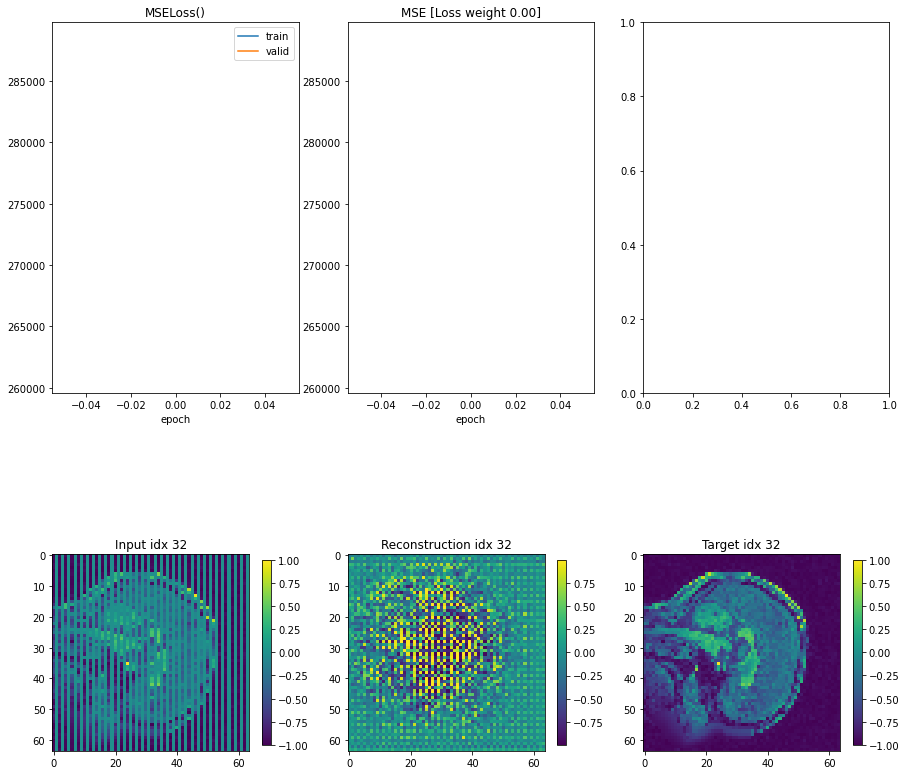

  0% (1 of 300) |                        | Elapsed Time: 0:00:01 ETA:   0:07:29
  0% (2 of 300) |                        | Elapsed Time: 0:00:02 ETA:   0:05:44
  1% (3 of 300) |                        | Elapsed Time: 0:00:03 ETA:   0:05:08
  1% (4 of 300) |                        | Elapsed Time: 0:00:03 ETA:   0:03:58
  1% (5 of 300) |                        | Elapsed Time: 0:00:04 ETA:   0:03:58


KeyboardInterrupt: 

In [8]:
model = make_model(channels=x_sample.shape[0])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_model(model, optimizer, l2loss, train_loader, wmse=0., valid_loader=None, nepochs=300, log_frequency=300, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 1433130.375, 'mse (weight 0.00)': tensor(274682., device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


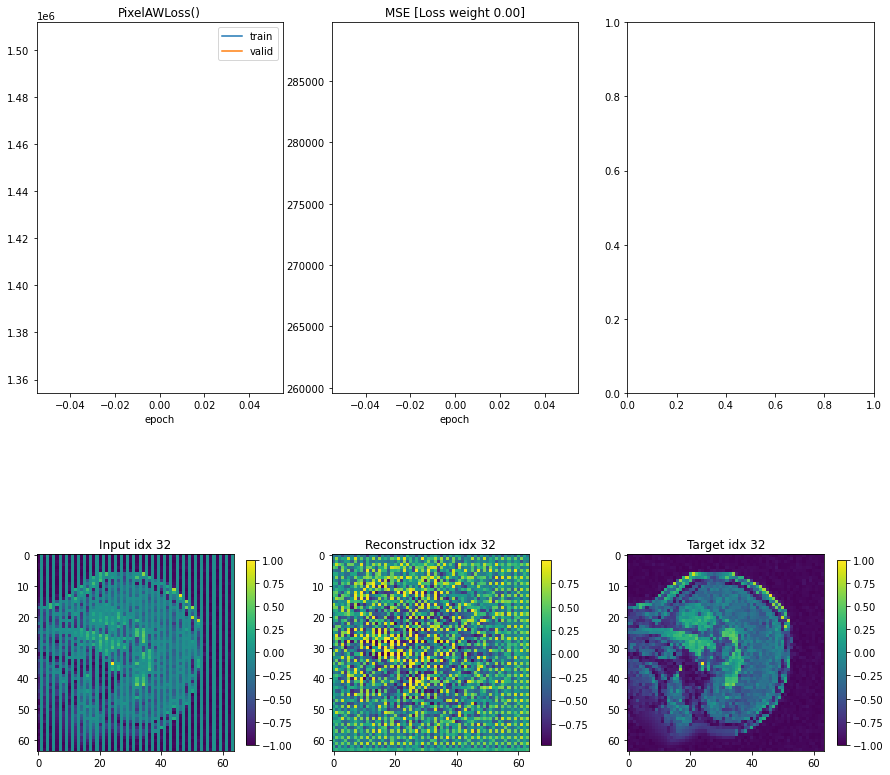

  0% (1 of 150) |                        | Elapsed Time: 0:00:01 ETA:   0:03:59
  1% (2 of 150) |                        | Elapsed Time: 0:00:02 ETA:   0:03:01
  2% (3 of 150) |                        | Elapsed Time: 0:00:03 ETA:   0:02:41
  2% (4 of 150) |                        | Elapsed Time: 0:00:04 ETA:   0:02:03
  3% (5 of 150) |                        | Elapsed Time: 0:00:04 ETA:   0:02:01
  4% (6 of 150) |                        | Elapsed Time: 0:00:05 ETA:   0:02:00
  4% (7 of 150) |#                       | Elapsed Time: 0:00:06 ETA:   0:01:59
  5% (8 of 150) |#                       | Elapsed Time: 0:00:07 ETA:   0:01:59
  6% (9 of 150) |#                       | Elapsed Time: 0:00:08 ETA:   0:01:59
  6% (10 of 150) |#                      | Elapsed Time: 0:00:09 ETA:   0:01:58



 {'epoch': 10, 'loss': 1484274.0, 'mse (weight 0.00)': tensor(197962.3906, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


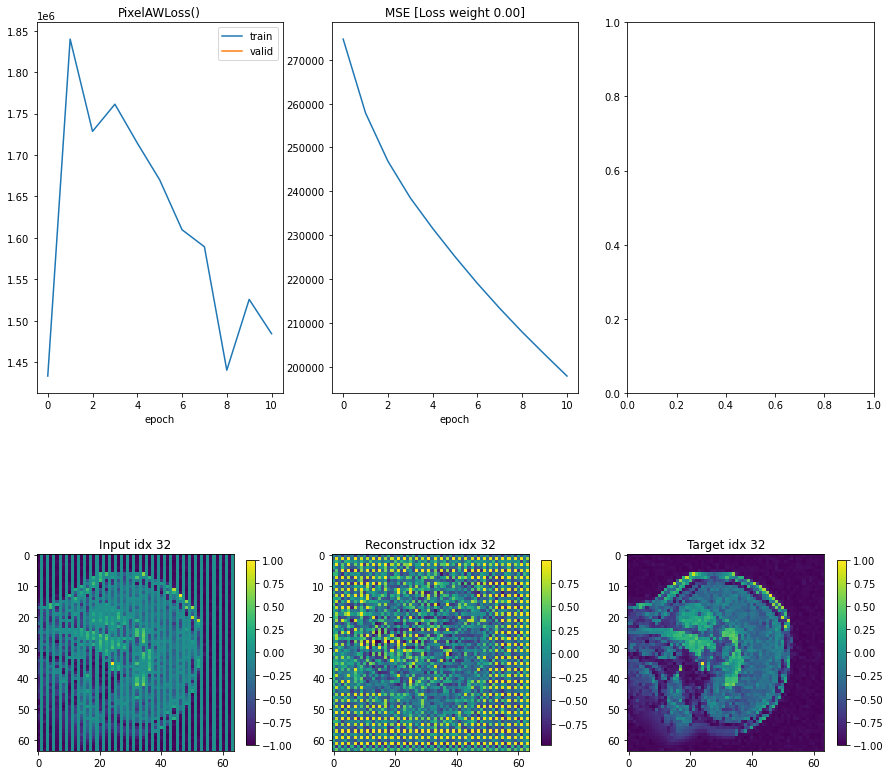

  7% (11 of 150) |#                      | Elapsed Time: 0:00:10 ETA:   0:02:47
  8% (12 of 150) |#                      | Elapsed Time: 0:00:11 ETA:   0:02:45
  8% (13 of 150) |#                      | Elapsed Time: 0:00:12 ETA:   0:02:27
  9% (14 of 150) |##                     | Elapsed Time: 0:00:13 ETA:   0:01:53
 10% (15 of 150) |##                     | Elapsed Time: 0:00:14 ETA:   0:01:53
 10% (16 of 150) |##                     | Elapsed Time: 0:00:14 ETA:   0:01:53
 11% (17 of 150) |##                     | Elapsed Time: 0:00:15 ETA:   0:01:52
 12% (18 of 150) |##                     | Elapsed Time: 0:00:16 ETA:   0:01:51
 12% (19 of 150) |##                     | Elapsed Time: 0:00:17 ETA:   0:01:49
 13% (20 of 150) |###                    | Elapsed Time: 0:00:18 ETA:   0:01:48



 {'epoch': 20, 'loss': 1077777.625, 'mse (weight 0.00)': tensor(159876.6875, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


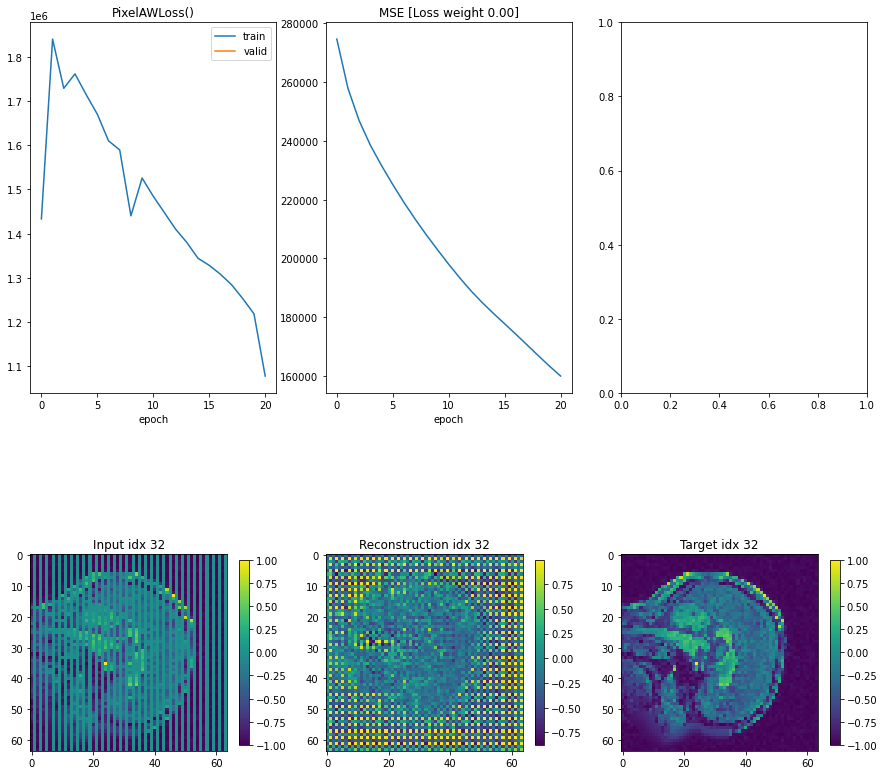

 14% (21 of 150) |###                    | Elapsed Time: 0:00:19 ETA:   0:02:34
 14% (22 of 150) |###                    | Elapsed Time: 0:00:20 ETA:   0:02:34
 15% (23 of 150) |###                    | Elapsed Time: 0:00:21 ETA:   0:02:17
 16% (24 of 150) |###                    | Elapsed Time: 0:00:22 ETA:   0:01:45
 16% (25 of 150) |###                    | Elapsed Time: 0:00:23 ETA:   0:01:45
 17% (26 of 150) |###                    | Elapsed Time: 0:00:24 ETA:   0:01:45
 18% (27 of 150) |####                   | Elapsed Time: 0:00:24 ETA:   0:01:44
 18% (28 of 150) |####                   | Elapsed Time: 0:00:25 ETA:   0:01:43
 19% (29 of 150) |####                   | Elapsed Time: 0:00:26 ETA:   0:01:42
 20% (30 of 150) |####                   | Elapsed Time: 0:00:27 ETA:   0:01:42



 {'epoch': 30, 'loss': 921146.5, 'mse (weight 0.00)': tensor(132880.2656, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


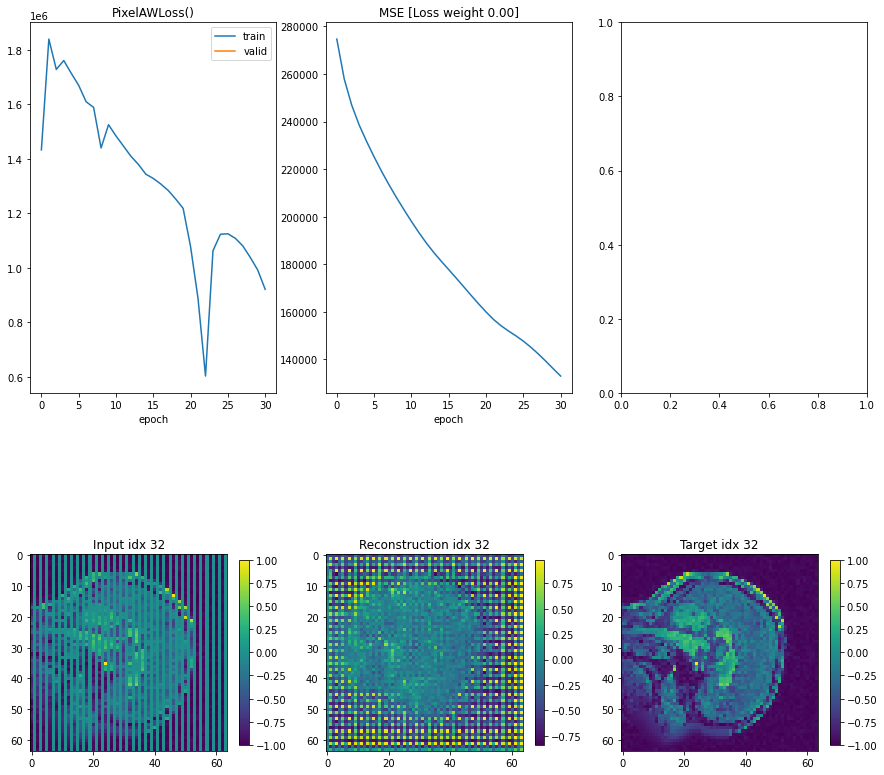

 20% (31 of 150) |####                   | Elapsed Time: 0:00:29 ETA:   0:02:28
 21% (32 of 150) |####                   | Elapsed Time: 0:00:30 ETA:   0:02:28
 22% (33 of 150) |#####                  | Elapsed Time: 0:00:30 ETA:   0:02:10
 22% (34 of 150) |#####                  | Elapsed Time: 0:00:31 ETA:   0:01:38
 23% (35 of 150) |#####                  | Elapsed Time: 0:00:32 ETA:   0:01:36
 24% (36 of 150) |#####                  | Elapsed Time: 0:00:33 ETA:   0:01:35
 24% (37 of 150) |#####                  | Elapsed Time: 0:00:34 ETA:   0:01:35
 25% (38 of 150) |#####                  | Elapsed Time: 0:00:35 ETA:   0:01:34
 26% (39 of 150) |#####                  | Elapsed Time: 0:00:35 ETA:   0:01:34
 26% (40 of 150) |######                 | Elapsed Time: 0:00:36 ETA:   0:01:33



 {'epoch': 40, 'loss': 485338.125, 'mse (weight 0.00)': tensor(104984.8047, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


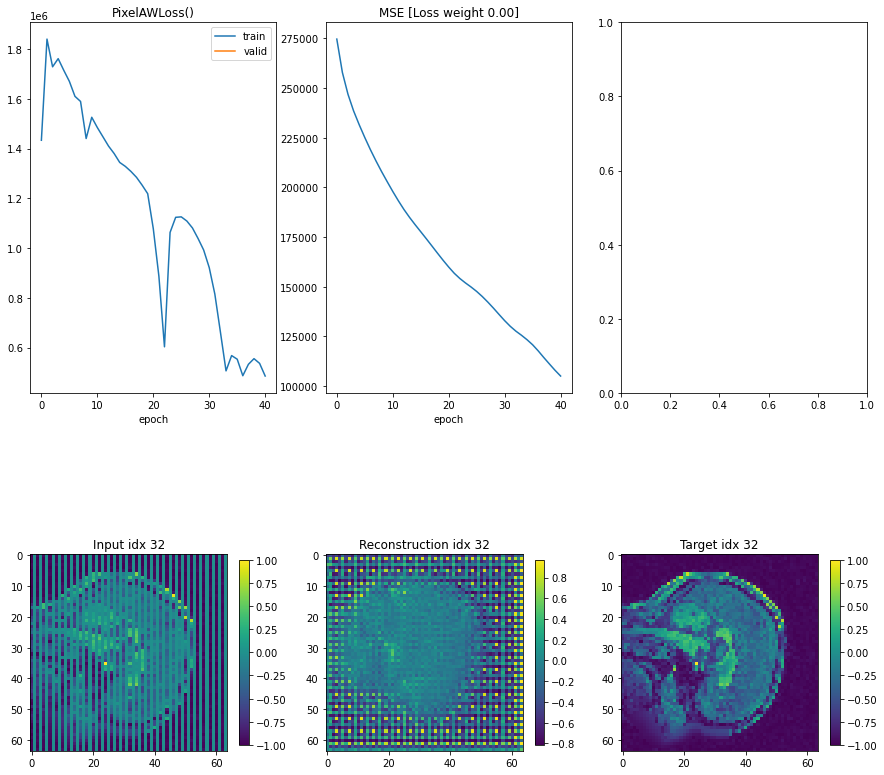

 27% (41 of 150) |######                 | Elapsed Time: 0:00:38 ETA:   0:02:12
 28% (42 of 150) |######                 | Elapsed Time: 0:00:39 ETA:   0:02:09
 28% (43 of 150) |######                 | Elapsed Time: 0:00:40 ETA:   0:01:55
 29% (44 of 150) |######                 | Elapsed Time: 0:00:40 ETA:   0:01:30
 30% (45 of 150) |######                 | Elapsed Time: 0:00:41 ETA:   0:01:29
 30% (46 of 150) |#######                | Elapsed Time: 0:00:42 ETA:   0:01:28
 31% (47 of 150) |#######                | Elapsed Time: 0:00:43 ETA:   0:01:26
 32% (48 of 150) |#######                | Elapsed Time: 0:00:44 ETA:   0:01:25
 32% (49 of 150) |#######                | Elapsed Time: 0:00:45 ETA:   0:01:25
 33% (50 of 150) |#######                | Elapsed Time: 0:00:45 ETA:   0:01:24



 {'epoch': 50, 'loss': 310326.65625, 'mse (weight 0.00)': tensor(85677.5312, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


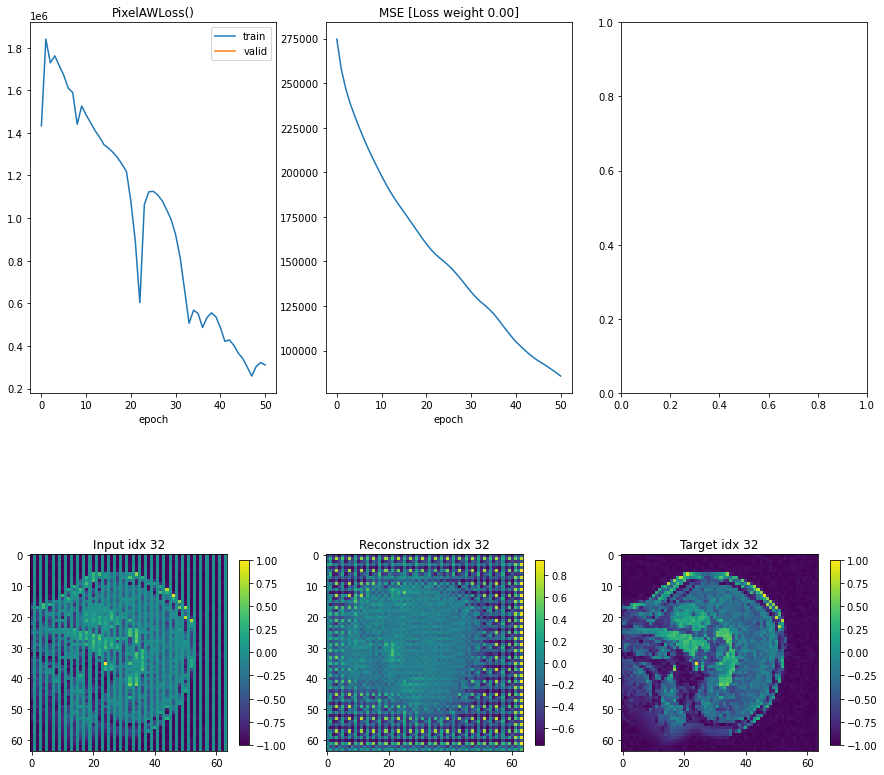

 34% (51 of 150) |#######                | Elapsed Time: 0:00:47 ETA:   0:01:59
 34% (52 of 150) |#######                | Elapsed Time: 0:00:48 ETA:   0:01:57
 35% (53 of 150) |########               | Elapsed Time: 0:00:49 ETA:   0:01:45
 36% (54 of 150) |########               | Elapsed Time: 0:00:50 ETA:   0:01:20
 36% (55 of 150) |########               | Elapsed Time: 0:00:50 ETA:   0:01:20
 37% (56 of 150) |########               | Elapsed Time: 0:00:51 ETA:   0:01:19
 38% (57 of 150) |########               | Elapsed Time: 0:00:52 ETA:   0:01:18
 38% (58 of 150) |########               | Elapsed Time: 0:00:53 ETA:   0:01:16
 39% (59 of 150) |#########              | Elapsed Time: 0:00:54 ETA:   0:01:16
 40% (60 of 150) |#########              | Elapsed Time: 0:00:55 ETA:   0:01:15



 {'epoch': 60, 'loss': 251087.75, 'mse (weight 0.00)': tensor(68111.9844, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


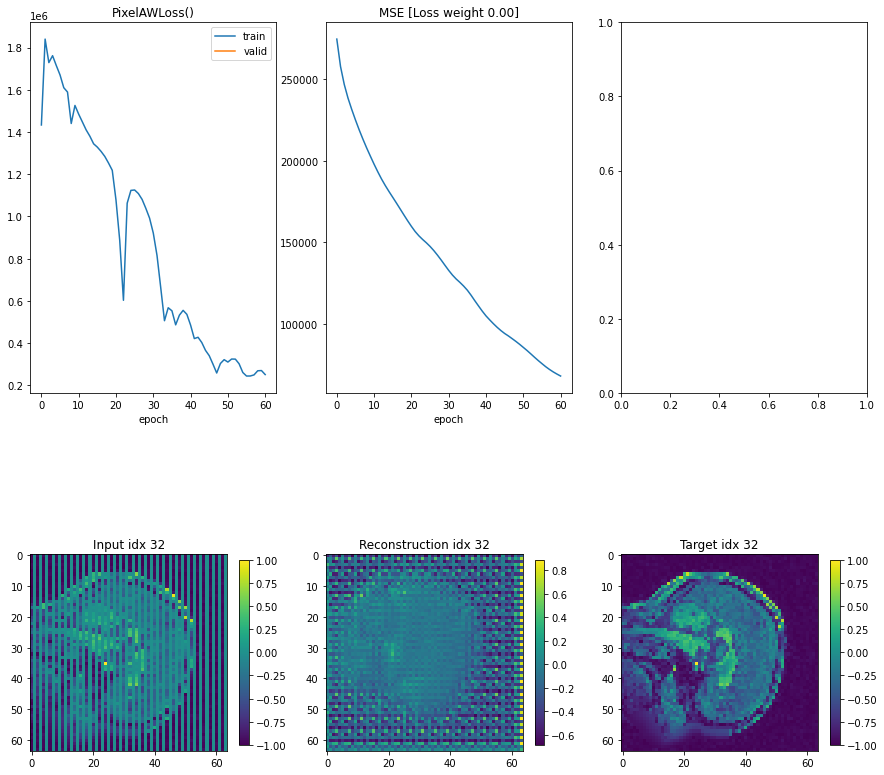

 40% (61 of 150) |#########              | Elapsed Time: 0:00:56 ETA:   0:01:52
 41% (62 of 150) |#########              | Elapsed Time: 0:00:57 ETA:   0:01:52
 42% (63 of 150) |#########              | Elapsed Time: 0:00:58 ETA:   0:01:38
 42% (64 of 150) |#########              | Elapsed Time: 0:00:59 ETA:   0:01:12
 43% (65 of 150) |#########              | Elapsed Time: 0:01:00 ETA:   0:01:11
 44% (66 of 150) |##########             | Elapsed Time: 0:01:01 ETA:   0:01:10
 44% (67 of 150) |##########             | Elapsed Time: 0:01:01 ETA:   0:01:09
 45% (68 of 150) |##########             | Elapsed Time: 0:01:02 ETA:   0:01:09
 46% (69 of 150) |##########             | Elapsed Time: 0:01:03 ETA:   0:01:08
 46% (70 of 150) |##########             | Elapsed Time: 0:01:04 ETA:   0:01:08



 {'epoch': 70, 'loss': 230295.78125, 'mse (weight 0.00)': tensor(58815.7188, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


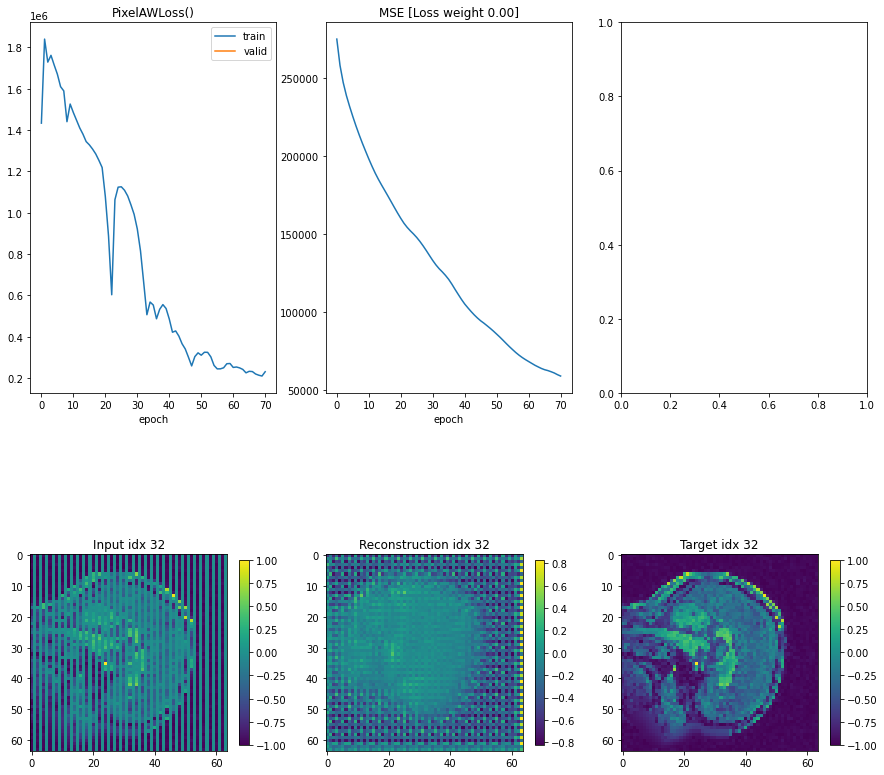

 47% (71 of 150) |##########             | Elapsed Time: 0:01:06 ETA:   0:01:36
 48% (72 of 150) |###########            | Elapsed Time: 0:01:06 ETA:   0:01:35
 48% (73 of 150) |###########            | Elapsed Time: 0:01:07 ETA:   0:01:24
 49% (74 of 150) |###########            | Elapsed Time: 0:01:08 ETA:   0:01:04
 50% (75 of 150) |###########            | Elapsed Time: 0:01:09 ETA:   0:01:03
 50% (76 of 150) |###########            | Elapsed Time: 0:01:10 ETA:   0:01:02
 51% (77 of 150) |###########            | Elapsed Time: 0:01:11 ETA:   0:01:01
 52% (78 of 150) |###########            | Elapsed Time: 0:01:11 ETA:   0:01:00
 52% (79 of 150) |############           | Elapsed Time: 0:01:12 ETA:   0:00:59
 53% (80 of 150) |############           | Elapsed Time: 0:01:13 ETA:   0:00:58



 {'epoch': 80, 'loss': 202016.875, 'mse (weight 0.00)': tensor(53288.0586, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


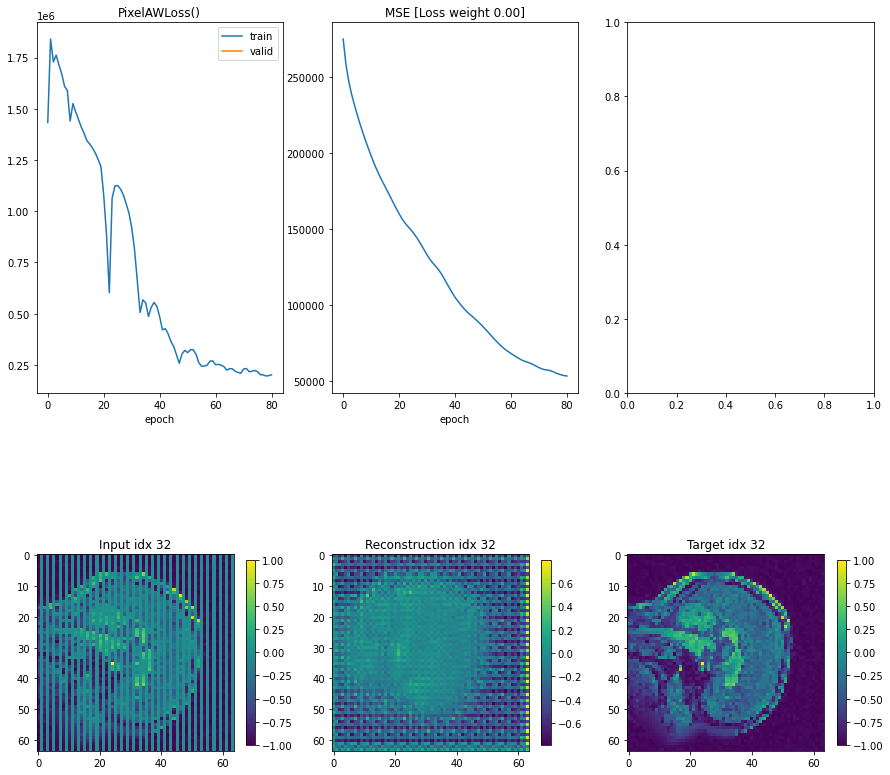

 54% (81 of 150) |############           | Elapsed Time: 0:01:15 ETA:   0:01:22
 54% (82 of 150) |############           | Elapsed Time: 0:01:16 ETA:   0:01:21
 55% (83 of 150) |############           | Elapsed Time: 0:01:16 ETA:   0:01:12
 56% (84 of 150) |############           | Elapsed Time: 0:01:17 ETA:   0:00:55
 56% (85 of 150) |#############          | Elapsed Time: 0:01:18 ETA:   0:00:54
 57% (86 of 150) |#############          | Elapsed Time: 0:01:19 ETA:   0:00:53
 58% (87 of 150) |#############          | Elapsed Time: 0:01:20 ETA:   0:00:53
 58% (88 of 150) |#############          | Elapsed Time: 0:01:21 ETA:   0:00:52
 59% (89 of 150) |#############          | Elapsed Time: 0:01:21 ETA:   0:00:52
 60% (90 of 150) |#############          | Elapsed Time: 0:01:22 ETA:   0:00:50



 {'epoch': 90, 'loss': 228207.3125, 'mse (weight 0.00)': tensor(48984.6797, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


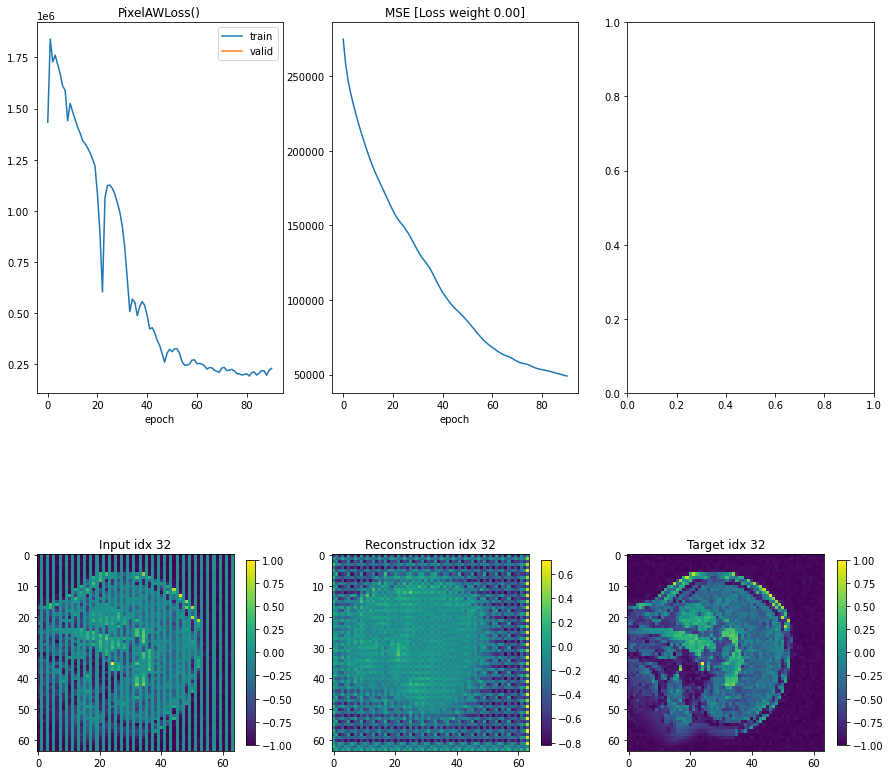

 60% (91 of 150) |#############          | Elapsed Time: 0:01:24 ETA:   0:01:13
 61% (92 of 150) |##############         | Elapsed Time: 0:01:25 ETA:   0:01:12
 62% (93 of 150) |##############         | Elapsed Time: 0:01:26 ETA:   0:01:03
 62% (94 of 150) |##############         | Elapsed Time: 0:01:26 ETA:   0:00:47
 63% (95 of 150) |##############         | Elapsed Time: 0:01:27 ETA:   0:00:46
 64% (96 of 150) |##############         | Elapsed Time: 0:01:28 ETA:   0:00:45
 64% (97 of 150) |##############         | Elapsed Time: 0:01:29 ETA:   0:00:44
 65% (98 of 150) |###############        | Elapsed Time: 0:01:30 ETA:   0:00:43
 66% (99 of 150) |###############        | Elapsed Time: 0:01:31 ETA:   0:00:43
 66% (100 of 150) |##############        | Elapsed Time: 0:01:32 ETA:   0:00:42



 {'epoch': 100, 'loss': 208991.03125, 'mse (weight 0.00)': tensor(45923.1445, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


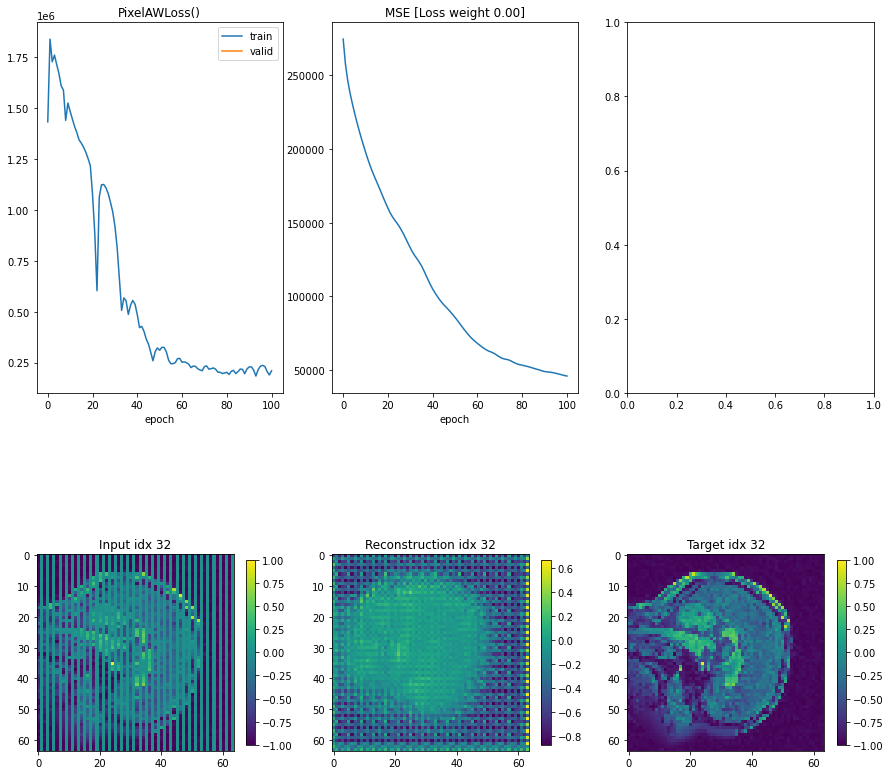

 67% (101 of 150) |##############        | Elapsed Time: 0:01:33 ETA:   0:00:59
 68% (102 of 150) |##############        | Elapsed Time: 0:01:34 ETA:   0:00:58
 68% (103 of 150) |###############       | Elapsed Time: 0:01:35 ETA:   0:00:51
 69% (104 of 150) |###############       | Elapsed Time: 0:01:36 ETA:   0:00:39
 70% (105 of 150) |###############       | Elapsed Time: 0:01:36 ETA:   0:00:38
 70% (106 of 150) |###############       | Elapsed Time: 0:01:37 ETA:   0:00:37
 71% (107 of 150) |###############       | Elapsed Time: 0:01:38 ETA:   0:00:36
 72% (108 of 150) |###############       | Elapsed Time: 0:01:39 ETA:   0:00:35
 72% (109 of 150) |###############       | Elapsed Time: 0:01:40 ETA:   0:00:35
 73% (110 of 150) |################      | Elapsed Time: 0:01:41 ETA:   0:00:33



 {'epoch': 110, 'loss': 208137.859375, 'mse (weight 0.00)': tensor(43743.5586, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


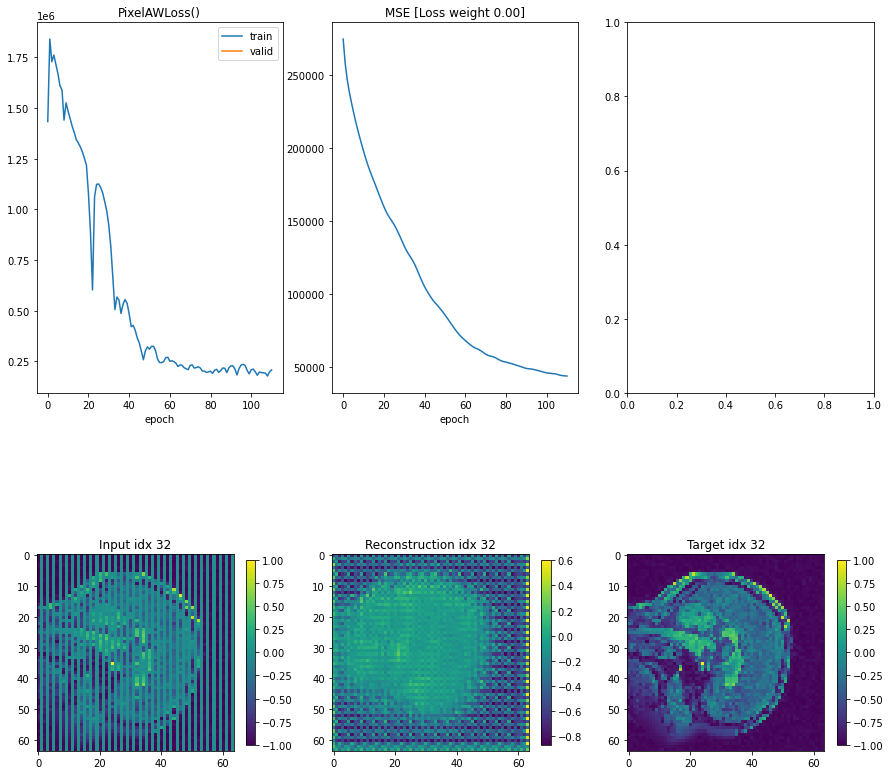

 74% (111 of 150) |################      | Elapsed Time: 0:01:42 ETA:   0:00:47
 74% (112 of 150) |################      | Elapsed Time: 0:01:43 ETA:   0:00:46
 75% (113 of 150) |################      | Elapsed Time: 0:01:44 ETA:   0:00:40
 76% (114 of 150) |################      | Elapsed Time: 0:01:45 ETA:   0:00:30
 76% (115 of 150) |################      | Elapsed Time: 0:01:46 ETA:   0:00:29
 77% (116 of 150) |#################     | Elapsed Time: 0:01:47 ETA:   0:00:28
 78% (117 of 150) |#################     | Elapsed Time: 0:01:47 ETA:   0:00:27
 78% (118 of 150) |#################     | Elapsed Time: 0:01:48 ETA:   0:00:26
 79% (119 of 150) |#################     | Elapsed Time: 0:01:49 ETA:   0:00:26
 80% (120 of 150) |#################     | Elapsed Time: 0:01:50 ETA:   0:00:25



 {'epoch': 120, 'loss': 180002.0, 'mse (weight 0.00)': tensor(41651.6953, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


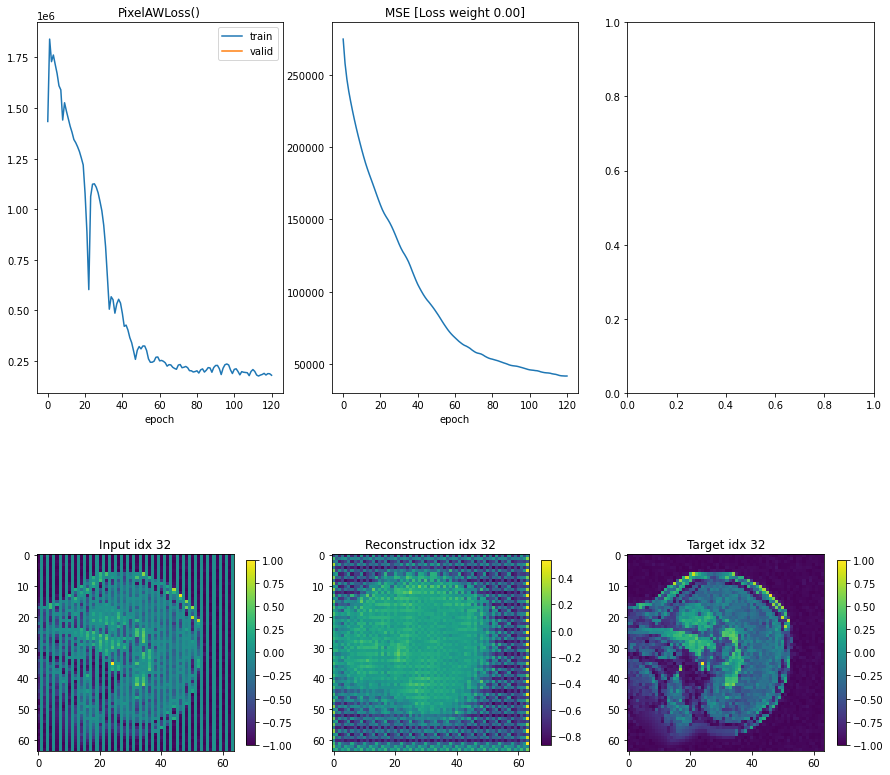

 80% (121 of 150) |#################     | Elapsed Time: 0:01:52 ETA:   0:00:36
 81% (122 of 150) |#################     | Elapsed Time: 0:01:52 ETA:   0:00:35
 82% (123 of 150) |##################    | Elapsed Time: 0:01:53 ETA:   0:00:30
 82% (124 of 150) |##################    | Elapsed Time: 0:01:54 ETA:   0:00:22
 83% (125 of 150) |##################    | Elapsed Time: 0:01:55 ETA:   0:00:21
 84% (126 of 150) |##################    | Elapsed Time: 0:01:56 ETA:   0:00:20
 84% (127 of 150) |##################    | Elapsed Time: 0:01:57 ETA:   0:00:19
 85% (128 of 150) |##################    | Elapsed Time: 0:01:58 ETA:   0:00:18
 86% (129 of 150) |##################    | Elapsed Time: 0:01:58 ETA:   0:00:17
 86% (130 of 150) |###################   | Elapsed Time: 0:01:59 ETA:   0:00:16



 {'epoch': 130, 'loss': 183012.28125, 'mse (weight 0.00)': tensor(39418.1719, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


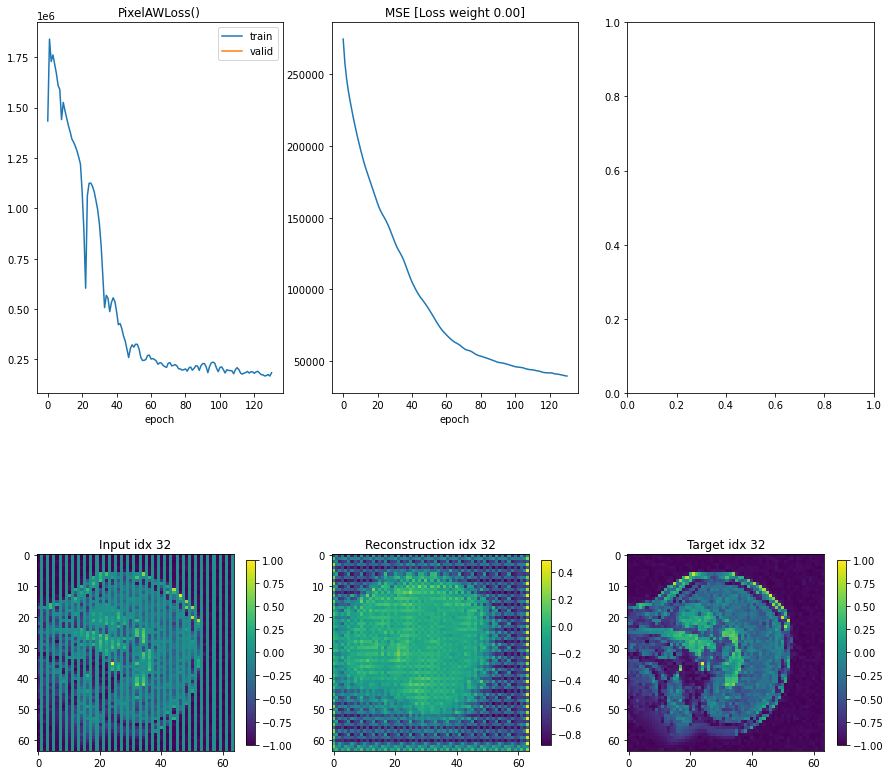

 87% (131 of 150) |###################   | Elapsed Time: 0:02:01 ETA:   0:00:23
 88% (132 of 150) |###################   | Elapsed Time: 0:02:02 ETA:   0:00:22
 88% (133 of 150) |###################   | Elapsed Time: 0:02:03 ETA:   0:00:18
 89% (134 of 150) |###################   | Elapsed Time: 0:02:03 ETA:   0:00:13
 90% (135 of 150) |###################   | Elapsed Time: 0:02:04 ETA:   0:00:12
 90% (136 of 150) |###################   | Elapsed Time: 0:02:05 ETA:   0:00:11
 91% (137 of 150) |####################  | Elapsed Time: 0:02:06 ETA:   0:00:11
 92% (138 of 150) |####################  | Elapsed Time: 0:02:07 ETA:   0:00:10
 92% (139 of 150) |####################  | Elapsed Time: 0:02:08 ETA:   0:00:09
 93% (140 of 150) |####################  | Elapsed Time: 0:02:08 ETA:   0:00:08



 {'epoch': 140, 'loss': 171074.265625, 'mse (weight 0.00)': tensor(38131.6523, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


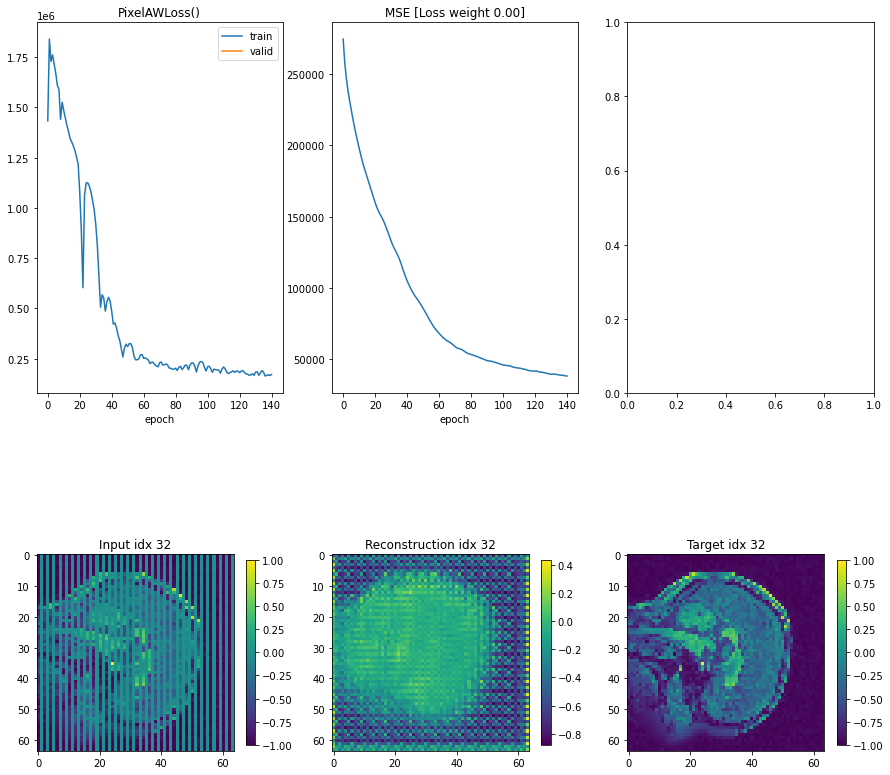

 94% (141 of 150) |####################  | Elapsed Time: 0:02:10 ETA:   0:00:11
 94% (142 of 150) |####################  | Elapsed Time: 0:02:11 ETA:   0:00:09
 95% (143 of 150) |####################  | Elapsed Time: 0:02:12 ETA:   0:00:07
 96% (144 of 150) |##################### | Elapsed Time: 0:02:13 ETA:   0:00:05
 96% (145 of 150) |##################### | Elapsed Time: 0:02:13 ETA:   0:00:04
 97% (146 of 150) |##################### | Elapsed Time: 0:02:14 ETA:   0:00:03
 98% (147 of 150) |##################### | Elapsed Time: 0:02:15 ETA:   0:00:02
 98% (148 of 150) |##################### | Elapsed Time: 0:02:16 ETA:   0:00:01
 99% (149 of 150) |##################### | Elapsed Time: 0:02:17 ETA:   0:00:00



 {'epoch': 149, 'loss': 166048.078125, 'mse (weight 0.00)': tensor(36966.4844, device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


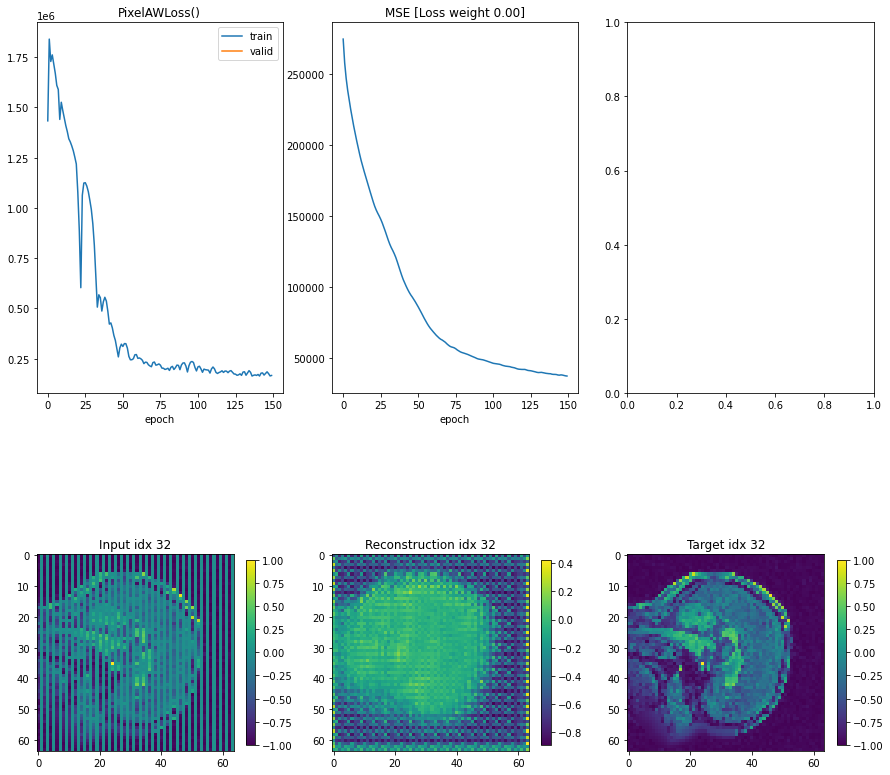

100% (150 of 150) |######################| Elapsed Time: 0:02:18 Time:  0:02:18


In [8]:
model = make_model(channels=x_sample.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, wmse=0.0, valid_loader=None, nepochs=150, log_frequency=10, sample_input=x_sample, sample_target=y_sample, device=device)



Training started ...


N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': -1097831.75, 'mse (weight 0.00)': tensor(274682., device='cuda:0', grad_fn=<AddBackward0>)}
torch.Size([64, 64, 64]) torch.Size([64, 64, 64])


AttributeError: 'PixelAWLoss' object has no attribute 'filters'

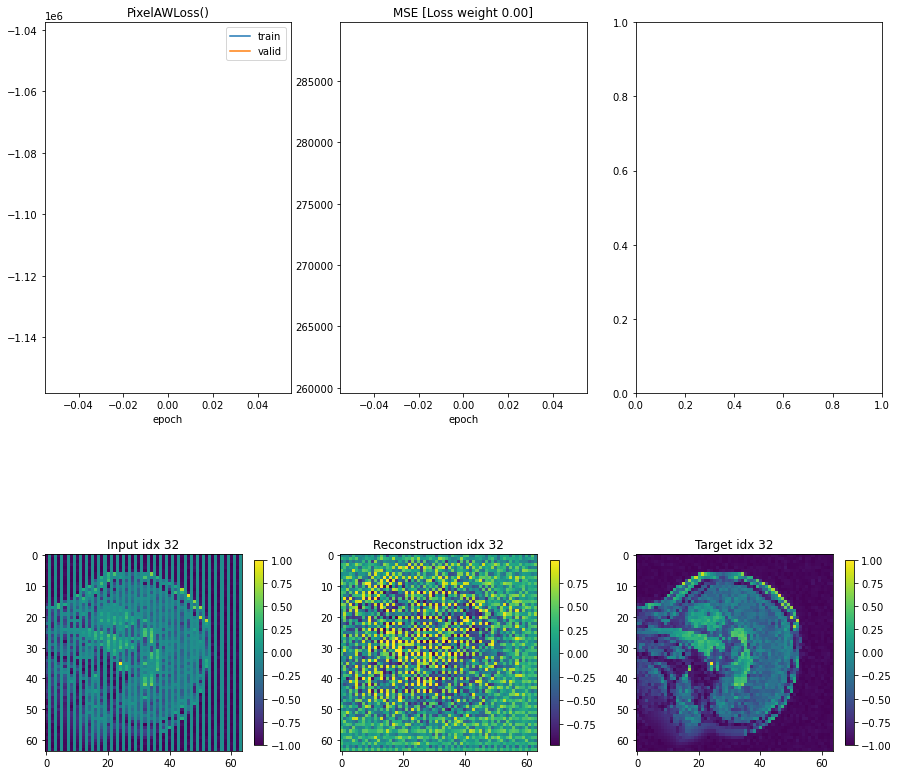

In [8]:
model = make_model(channels=x_sample.shape[0])

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, awloss, train_loader, wmse=1e-3, valid_loader=None, nepochs=600, log_frequency=300, sample_input=x_sample, sample_target=y_sample, device=device)